In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import sys
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
sys.path.append(os.path.abspath("../"))
from src.data.load_data import load_dataset
sys.path.append(os.path.abspath("../src")) 
from src.utils.helpers import add_ticket_repetition, get_personal_title
from src.features.pipe_config import preprocessing_pipeline


In [2]:
df = load_dataset('../data/raw/Titanic-dataset.csv') # Loading data

In [3]:
df = load_dataset('../data/raw/Titanic-dataset.csv')
idx2drop = df[df['Embarked'].isnull()].index
df = df.drop(idx2drop, axis=0)

### T/T split

X = df.drop('Survived',axis=1)
y = df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_save = X_train
preprocess = Pipeline(preprocessing_pipeline().steps[:-1])
X_train_trans = preprocess.fit_transform(X_train, y_train)
train= pd.concat([X_train, y_train], axis=1)
train_processed = pd.concat([X_train_trans, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
# train.to_csv('../data/raw/train.csv')
# test.to_csv('../data/raw/test.csv')

### Metadata
| **Column**       | **Description**                                         | **Type**             |
|------------------|----------------------------------------------------------|----------------------|
| PassengerId      | Unique passenger ID                                      | Numeric              |
| Survived         | Survival (0 = No, 1 = Yes)                               | Binary nominal       |
| Pclass           | Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd)                 | Ordinal numeric      |
| Name             | Name of passenger                                        | Character            |
| Sex              | Gender                                                   | Binary nominal       |
| Age              | Age (in years)                                           | Numeric (quotient)   |
| SibSp            | Number of siblings/spouses aboard                        | Numeric (quotient)   |
| Parch            | Number of parents/children aboard the Titanic            | Numeric (quotient)   |
| Ticket           | Ticket number                                            | Nominal              |
| Fare             | Passenger fare (money paid for ticket)                   | Numeric (quotient)   |
| Cabin            | Cabin number                                             | Nominal              |
| Embarked         | Port of Emb chebourg(C), quennstown(Q), Southampton(S)   | Nominal              |

In [6]:
df.isnull().sum().sort_values(ascending = False)

Cabin          687
Age            177
Embarked         2
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
dtype: int64

### Ticket repetition

In [22]:
df = add_ticket_repetition(df) #adding variable. 1 = more than one person on one ticket , 0 - one person on one ticket
df = get_personal_title(df)
df['Family_size'] = df['SibSp'] + df['Parch']

<Axes: xlabel='Age', ylabel='Fare'>

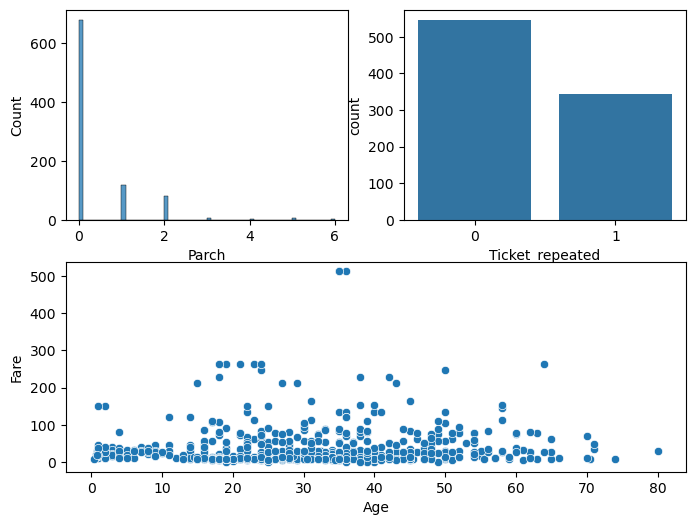

In [28]:
plt.figure(figsize=(8,6))

plt.subplot(2,2,1)
sns.histplot(df['Parch'])
plt.subplot(2,2,2)
sns.countplot(data=df, x='Ticket_repeated')
plt.subplot(2,1,2)
sns.scatterplot(data=df, x='Age', y='Fare')

In [ ]:
plt.gca()

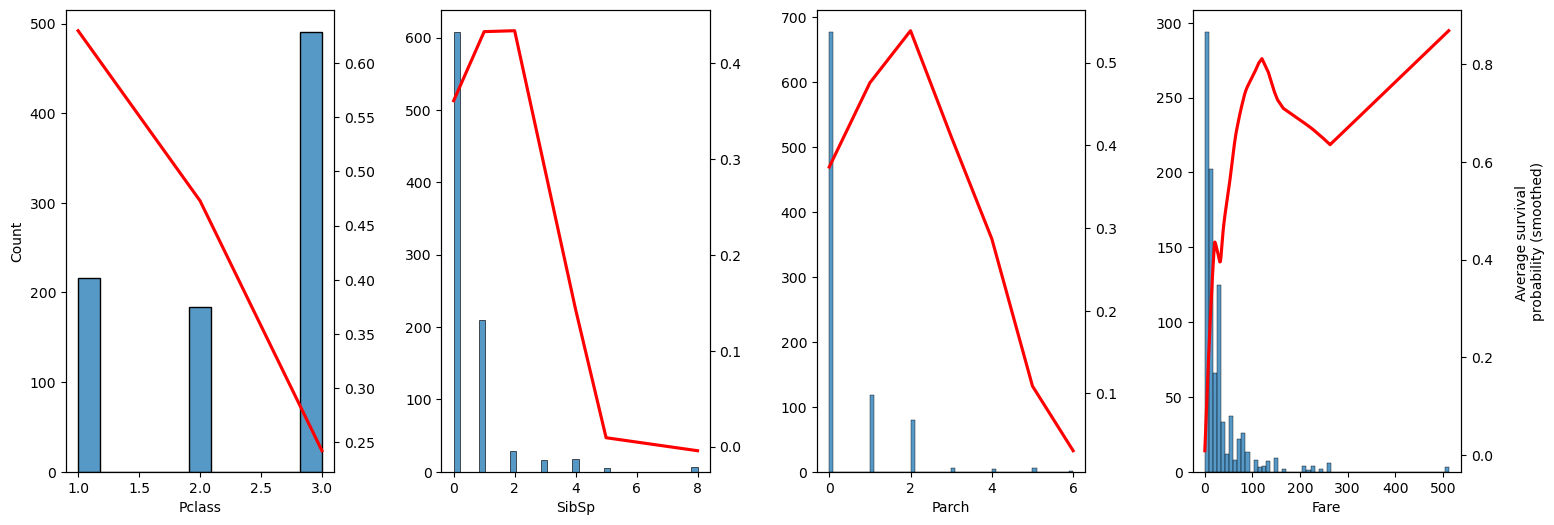

In [32]:
plt.figure(figsize=(18,6))
plt.subplots_adjust(wspace=0.4)
for i,x in enumerate(['Pclass','SibSp', 'Parch', 'Fare']):
    plt.subplot(1,4,i+1)
    sns.histplot(df[x])
    group_mean = df.groupby(df[x])['Survived'].mean()
    ax = plt.gca()
    ax2=ax.twinx()
    sns.regplot(x=group_mean.index, y=list(group_mean),lowess=True,scatter=False, color='red')
    if i == 0:
        ax.set_ylabel('Count')
    else:
        ax.set_ylabel('')
    if i == 3:
        ax2.set_ylabel('\nAverage survival \nprobability (smoothed)')
    

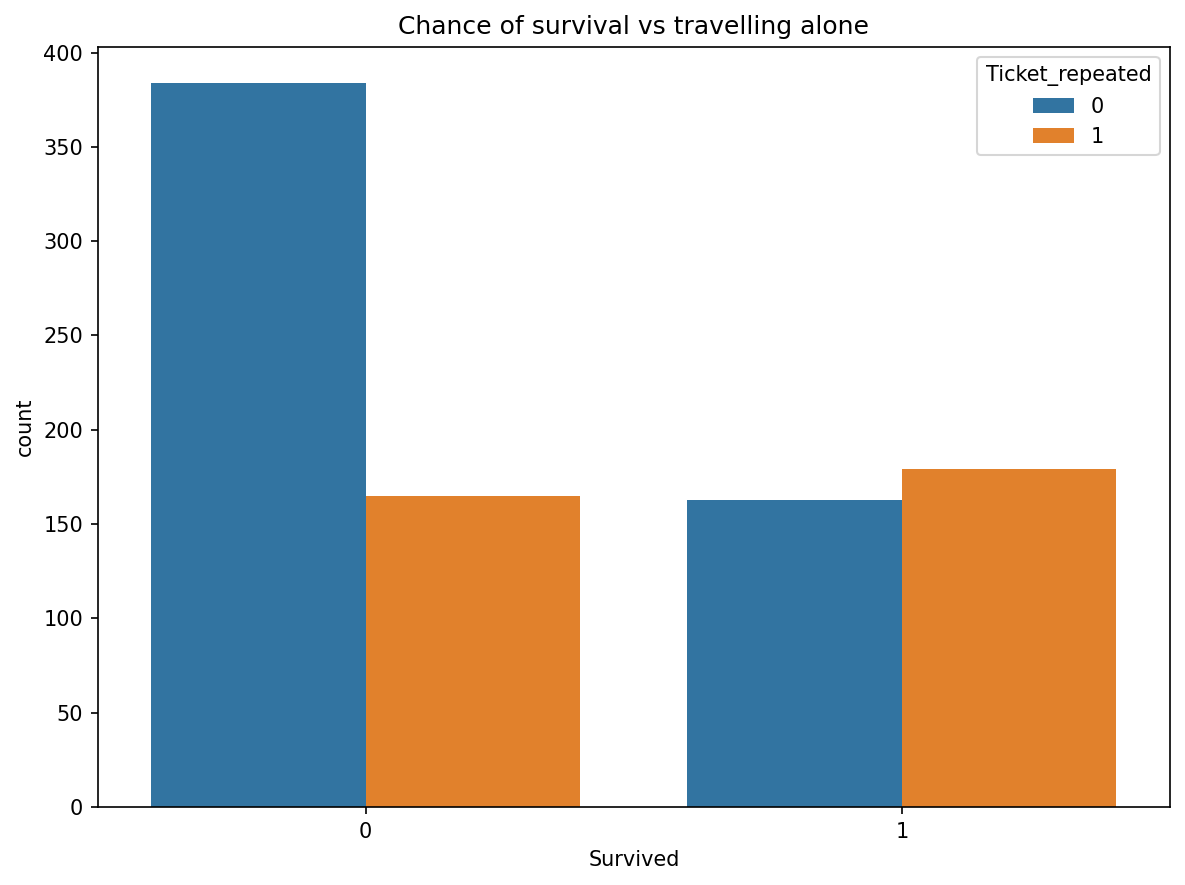

In [9]:
plt.figure(figsize=(8,6), dpi=150)
sns.countplot(data=df, x='Survived', hue = 'Ticket_repeated')
plt.title('Chance of survival vs travelling alone')
plt.tight_layout()
plt.savefig('../reports/figures/02_travelling_alone.jpg')


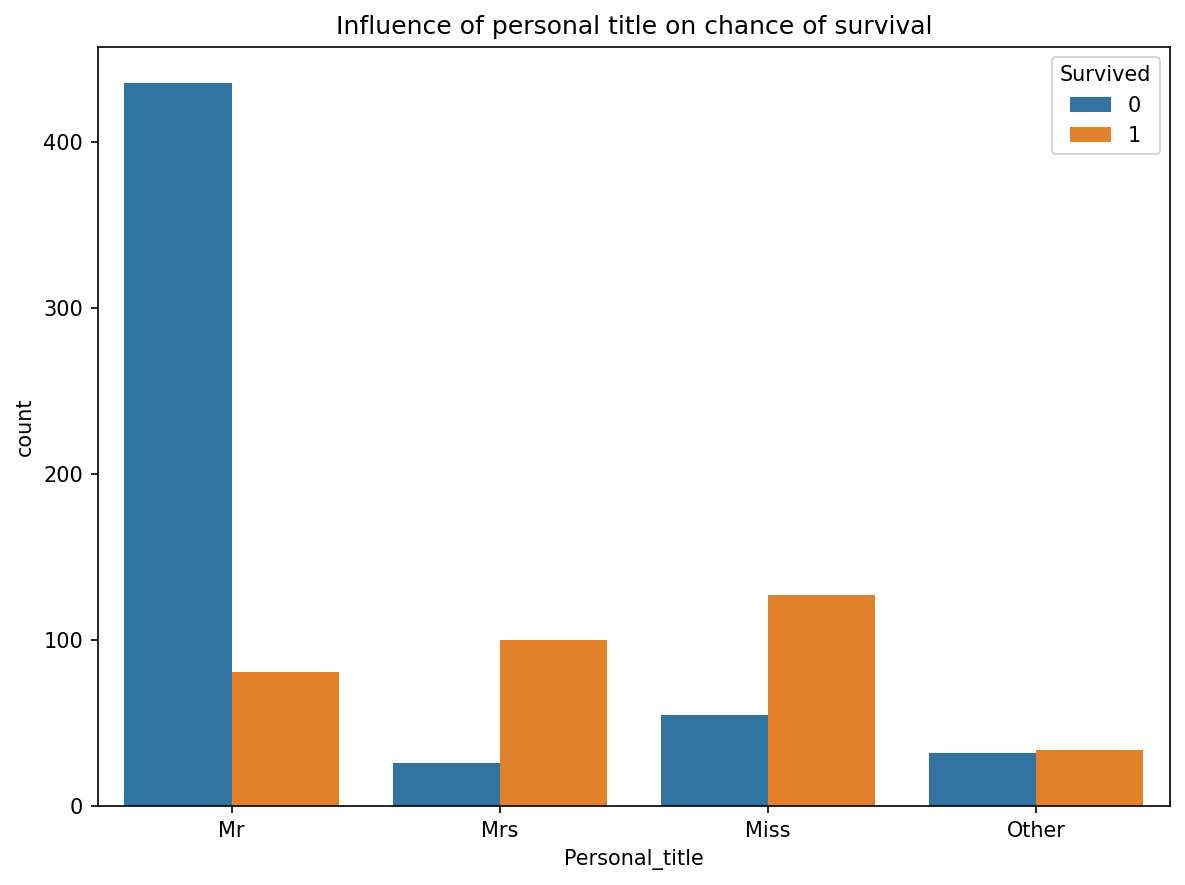

In [10]:
plt.figure(figsize=(8,6), dpi=150)
sns.countplot(data = df, x = 'Personal_title', hue='Survived')
plt.title('Influence of personal title on chance of survival')
plt.tight_layout()
plt.savefig('../reports/figures/01_personal_title.jpg')

### Children/parents/spouses/siblings
Try to create a new variable:
- single mother (female > 18, parch >0, sibsp =0)
- single father (male > 18, parch >0, sibsp =0)
- mother wife (female >18, parch >0, sibsp >1)

In [12]:
df.loc[:,['Parch','SibSp']] #Family, 

,Parch,SibSp
0,0,1
1,0,1
2,0,0
3,0,1
4,0,0
...,...,...
886,0,0
887,0,0
888,2,1
889,0,0


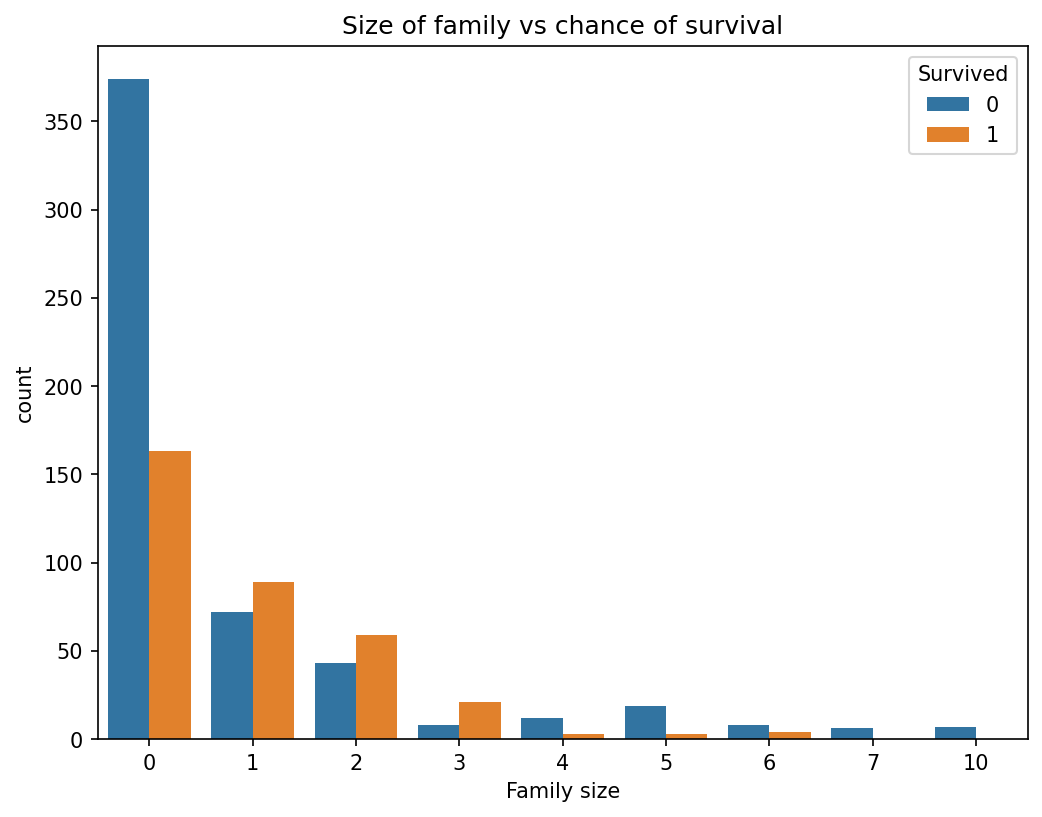

In [14]:
plt.figure(figsize = (8, 6), dpi = 150)
sns.countplot(data=df, x='Family_size', hue='Survived')
plt.xlabel('Family size')
plt.ylabel('count')
plt.title('Size of family vs chance of survival')
plt.savefig('../reports/figures/04_family_size.jpg')

### Class

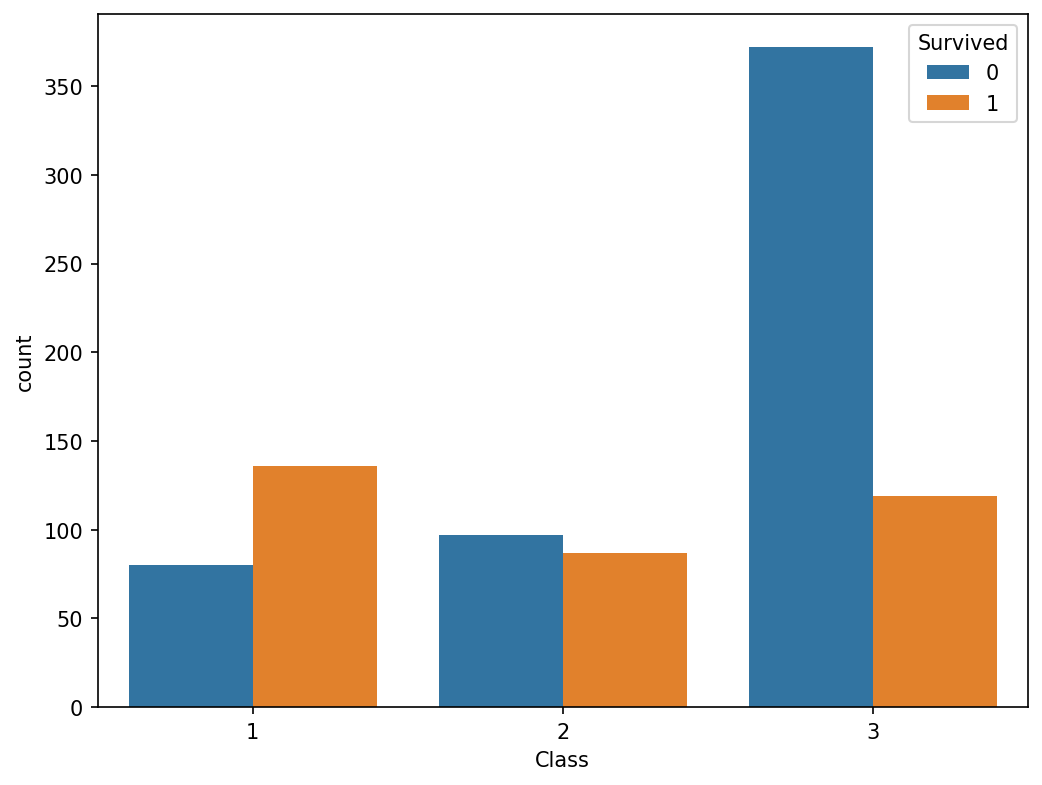

In [15]:
plt.figure(figsize = (8, 6), dpi = 150)
sns.countplot(data = df, x='Pclass', hue='Survived')
plt.xlabel('Class')
plt.savefig('../reports/figures/05_Ticket_class.jpg')


### Gender mapping
- 0 = female
- 1 = male

In [16]:
sex_map = {'female' : 0,
           'male' : 1}

df['Sex'] = df['Sex'].map(sex_map)

### Age EDA

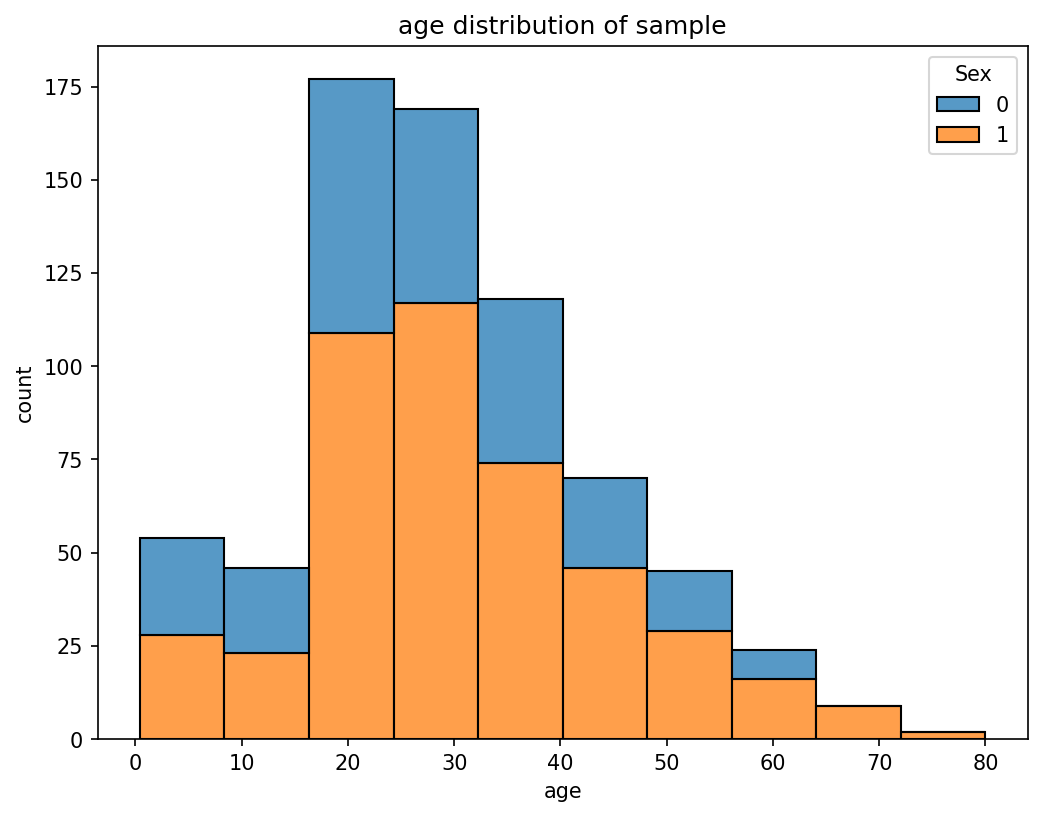

In [17]:
# counts, bins = np.histogram(df['Age'])

plt.figure(figsize = (8, 6), dpi = 150)
sns.histplot(data = df,
             x = 'Age', hue = 'Sex', bins=10, multiple = 'stack')
plt.xlabel('age')
plt.ylabel('count')
plt.title('age distribution of sample')
plt.savefig('../reports/figures/03_age_distribution.jpg')

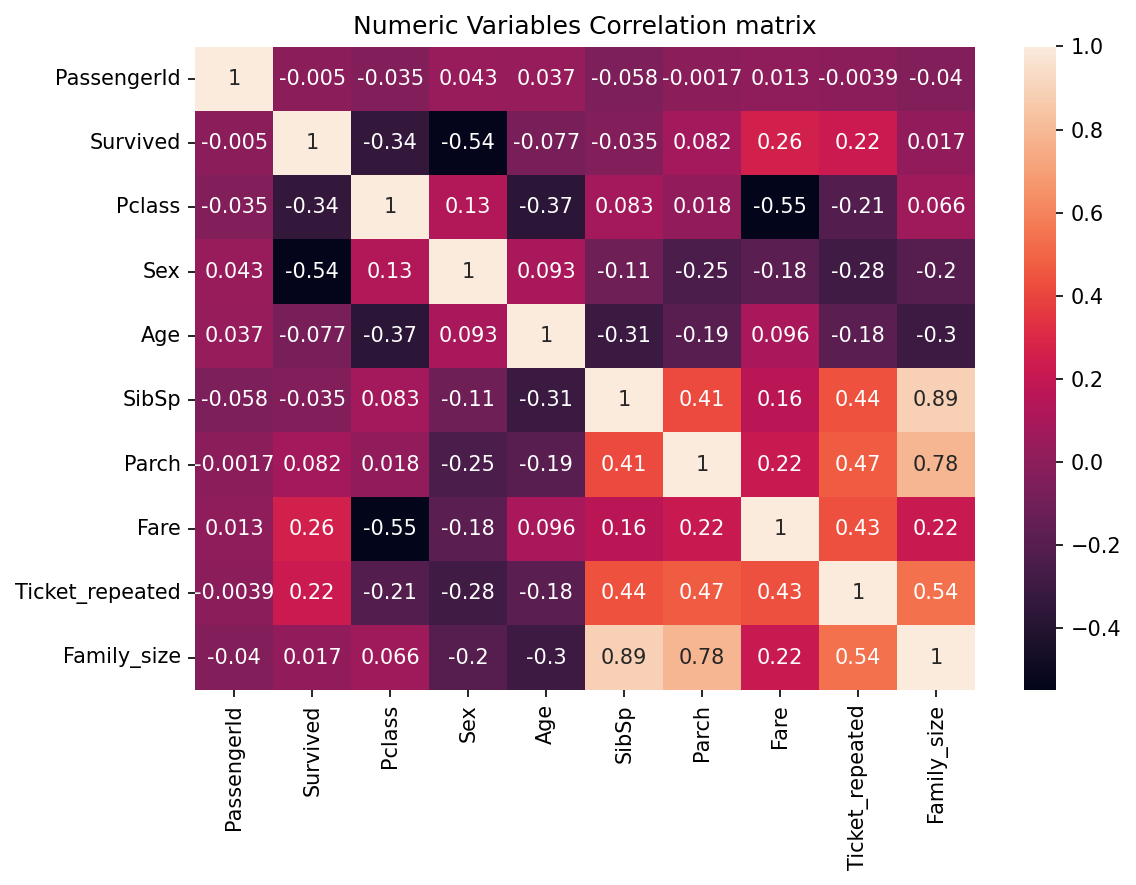

In [18]:
plt.figure(figsize = (8,6), dpi=150)
sns.heatmap(df.corr(numeric_only=True), annot=True)
plt.title('Numeric Variables Correlation matrix')
plt.tight_layout()
plt.savefig('../reports/figures/06_Corr_matrix.jpg')